## About
This program predicts the future prices of a stock using SARIMA (Seasonal Auto Regressive Integrated Moving Average).

## Import modules

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from datetime import datetime
from dateutil.relativedelta import relativedelta
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.tools import diff
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from pmdarima import auto_arima
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings("ignore")

sns.set_style('darkgrid')
%matplotlib inline

## Download the historical data

#### Set start date and end date

In [2]:
end_date = '2021-05-22'
end_date = datetime.strptime(end_date, '%Y-%m-%d')
start_date = end_date - relativedelta(years=12)

#### Fetch data from Yahoo Finance

In [3]:
ticker = 'INTC'
df = pd.DataFrame()
df[ticker] = yf.download(ticker, start=start_date, end=end_date)['Close']

[*********************100%***********************]  1 of 1 completed


#### Resample historical data to month start frequency

In [4]:
df = df.resample(rule='MS').ffill().dropna()
df.head(5)

,INTC
Date,
2009-06-01,16.500000
2009-07-01,17.040001
2009-08-01,19.250000
2009-09-01,19.719999
2009-10-01,18.900000


#### Plot the source data

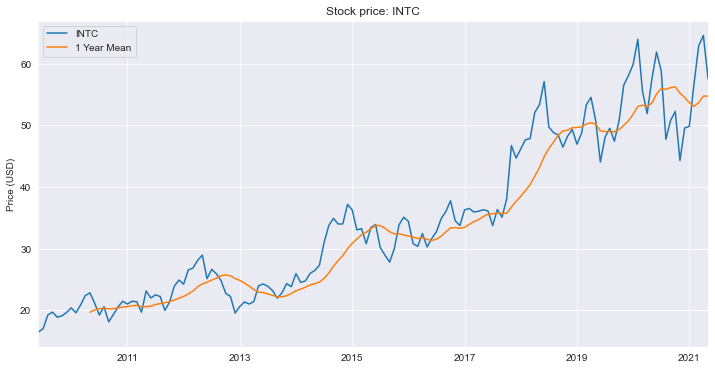

In [5]:
df['1 Year Mean'] = df.rolling(window=12).mean()
title='Stock price: ' + ticker
ylabel='Price (USD)'
xlabel=''
ax = df.plot(figsize=(12, 6), title=title)
ax.autoscale(tight=True, axis='x')
ax.set(xlabel='', ylabel=ylabel)
df.drop('1 Year Mean', inplace=True, axis=1)

## Optional: Run ETS (Error-Trend-Seasonality) decomposition

In [6]:
trading_days_year = 12
trading_days_quarter = 4
trading_days_month = 1
result = seasonal_decompose(df[ticker], model='add', freq=trading_days_year)

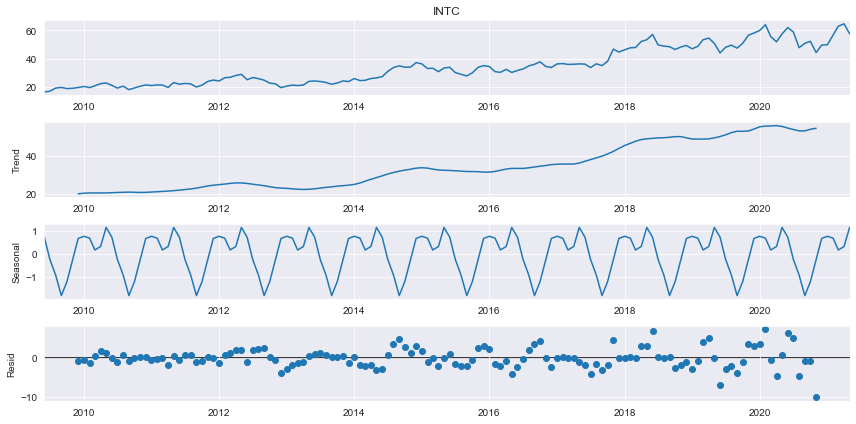

In [7]:
plt.rc("figure", figsize=(12,6))
result.plot();

## Run <tt>pmdarima.auto_arima</tt> to obtain recommended orders

In [8]:
stepwise_fit = auto_arima(df[ticker], start_p=0, start_q=0,
                          max_p=4, max_q=4, m=trading_days_year,
                          seasonal=True,
                          d=None, D=1, trace=True,
                          error_action='ignore',
                          suppress_warnings=True,
                          stepwise=True)

stepwise_fit.summary()

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(1,1,1)[12] intercept   : AIC=820.939, Time=0.17 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=858.476, Time=0.01 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=679.868, Time=0.10 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=721.287, Time=0.09 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=887.773, Time=0.01 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=751.919, Time=0.03 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=677.256, Time=0.19 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=0.71 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=672.440, Time=0.15 sec
 ARIMA(1,0,0)(0,1,1)[12] intercept   : AIC=inf, Time=0.33 sec
 ARIMA(1,0,0)(1,1,2)[12] intercept   : AIC=671.678, Time=0.35 sec
 ARIMA(1,0,0)(0,1,2)[12] intercept   : AIC=677.085, Time=0.27 sec
 ARIMA(1,0,0)(2,1,2)[12] intercept   : AIC=inf, Time=0.94 sec
 ARIMA(0,0,0)(1,1,2)[12] intercept   : AIC=822.891, Time=0.51 sec
 ARIMA(2,0,0)(1,1,2)[12] intercept   : AIC=67

<class 'statsmodels.iolib.summary.Summary'>
"""
                                        SARIMAX Results                                        
===============================================================================================
Dep. Variable:                                       y   No. Observations:                  144
Model:             SARIMAX(1, 0, 0)x(1, 1, [1, 2], 12)   Log Likelihood                -329.839
Date:                                 Tue, 24 Aug 2021   AIC                            671.678
Time:                                         14:23:30   BIC                            688.975
Sample:                                              0   HQIC                           678.706
                                                 - 144                                         
Covariance Type:                                   opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.8618      0.399      2.160      0.031       0.080       1.644
ar.L1          0.8562      0.049     17.557      0.000       0.761       0.952
ar.S.L12      -0.7214      0.214     -3.370      0.001      -1.141      -0.302
ma.S.L12      -0.4080      0.252     -1.619      0.106      -0.902       0.086
ma.S.L24      -0.3107      0.232     -1.340      0.180      -0.765       0.144
sigma2         7.4316      0.840      8.851      0.000       5.786       9.077
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                14.83
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               7.28   Skew:                            -0.42
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.41
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [9]:
auto_order = stepwise_fit.get_params()['order']
auto_season_order = stepwise_fit.get_params()['seasonal_order']
print('SARIMA order = ',auto_order)
print('SARIMA seasonal order = ',auto_season_order)

SARIMA order =  (1, 0, 0)
SARIMA seasonal order =  (1, 1, 2, 12)


## Create the SARIMA(p,d,q)(P,D,Q)m model

#### Split the data into train/test sets


In [10]:
n = int(len(df) * 0.8)
train = df[ticker][:n]
test = df[ticker][n:]
print(len(train))
print(len(test))

115
29


#### Fit an SARIMA(p,d,q)(P,D,Q)m Model


In [11]:
model = SARIMAX(train,order=auto_order,seasonal_order=auto_season_order)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                        SARIMAX Results                                        
===============================================================================================
Dep. Variable:                                    INTC   No. Observations:                  115
Model:             SARIMAX(1, 0, 0)x(1, 1, [1, 2], 12)   Log Likelihood                -229.721
Date:                                 Tue, 24 Aug 2021   AIC                            469.443
Time:                                         14:23:31   BIC                            482.616
Sample:                                     06-01-2009   HQIC                           474.778
                                          - 12-01-2018                                         
Covariance Type:                                   opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9866      0.017     59.374      0.000       0.954       1.019
ar.S.L12      -0.6625      0.494     -1.342      0.179      -1.630       0.305
ma.S.L12      -0.2144      0.584     -0.367      0.713      -1.359       0.930
ma.S.L24      -0.3516      0.465     -0.756      0.449      -1.263       0.560
sigma2         4.4767      0.593      7.553      0.000       3.315       5.638
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):                 7.39
Prob(Q):                              0.87   Prob(JB):                         0.02
Heteroskedasticity (H):               3.06   Skew:                            -0.16
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.27
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

#### Obtain predicted values

In [12]:
start=len(train)
end=len(train)+len(test)-1
prediction = results.get_prediction(start=start, end=end, dynamic=False, typ='levels')

In [13]:
model_name = 'SARIMA Prediction'
pred  = prediction.predicted_mean
lower = prediction.conf_int().iloc[:,0]
upper = prediction.conf_int().iloc[:,1]

#### Evaluate the Model

In [14]:
error = mean_squared_error(test, pred)
print(f'{model_name} MSE Error: {error:11.10}')
print(f'{model_name} RMSE Error: {np.sqrt(error):11.10}')

SARIMA Prediction MSE Error: 29.37245695
SARIMA Prediction RMSE Error: 5.419636238


#### Plot predictions against expected values


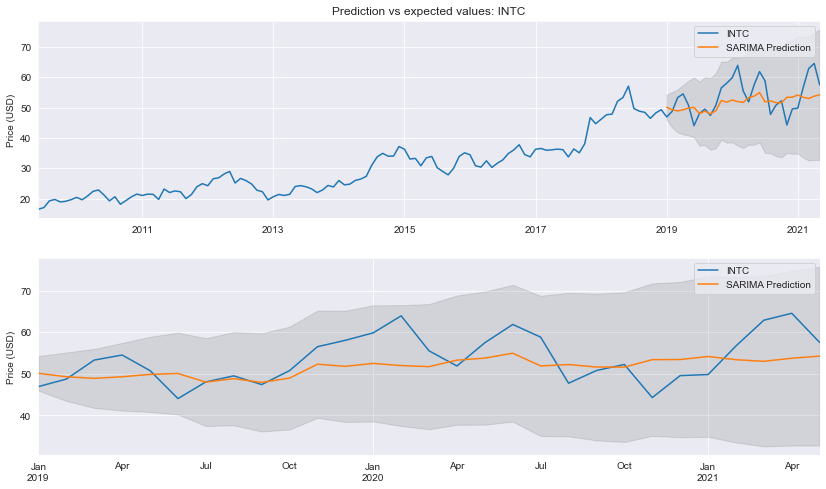

In [15]:
title='Prediction vs expected values: ' + ticker
ylabel='Price (USD)'
xlabel=''
fig, ax = plt.subplots(2, 1)

df[ticker].plot(legend=True, figsize=(14,8), title=title, ax=ax[0])
pred.plot(legend=True,ax=ax[0], label=model_name)

test.plot(legend=True, ax=ax[1])
pred.plot(legend=True, ax=ax[1], label=model_name)
for i in range(2):
    ax[i].autoscale(tight=True, axis='x')
    ax[i].set(xlabel=xlabel, ylabel=ylabel)
    ax[i].fill_between(lower.index, lower, upper, color="k", alpha=0.1);

## Forecast future data

#### Retrain the model on the full data, and forecast the future

In [16]:
model = SARIMAX(df[ticker],order=auto_order,seasonal_order=auto_season_order)
results = model.fit()
fcast_days = len(test)
forecast = results.get_prediction(start=len(df), end=len(df)+fcast_days, dynamic=False, typ='levels')

In [17]:
model_name = 'SARIMA Forecast'
fcast = forecast.predicted_mean
lower = forecast.conf_int().iloc[:,0]
upper = forecast.conf_int().iloc[:,1]

#### Plot forecast data

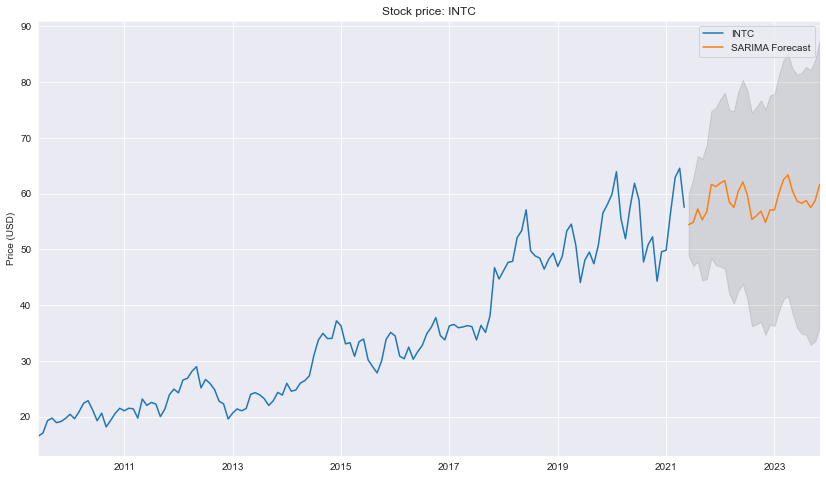

In [18]:
title='Stock price: ' + ticker
ylabel='Price (USD)'
xlabel=''

ax = df[ticker].plot(legend=True,figsize=(14,8),title=title)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);
fcast.plot(legend=True, label=model_name)
ax.fill_between(lower.index, lower, upper, color="k", alpha=0.1);